# Segunda parte: Aspectos prácticos de las redes neuronales

En esta segunda parte, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [37]:
# Puedes añadir todos los imports adicionales que necesites aquí
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.initializers import Zeros, RandomNormal, GlorotUniform
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

## Consideraciones iniciales

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [18]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1 *(1.25 puntos)***: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

Primero se entrenará un red neuronal totalmente conectada utilizando la función sigmoide en todas las *hidden layers* de la red.

In [33]:
model_sigmoid = Sequential()
model_sigmoid.add(Flatten(input_shape=[28, 28, 1]))
model_sigmoid.add(Dense(128, activation="sigmoid"))
model_sigmoid.add(Dense(64, activation="sigmoid"))
model_sigmoid.add(Dense(32, activation="sigmoid"))
model_sigmoid.add(Dense(10, activation="softmax"))
model_sigmoid.summary()

model_sigmoid.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_sigmoid = model_sigmoid.fit(
    x_train,
    y_train, 
    epochs=60,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_55 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
750/750 [==============================] - 1s 626us/step - loss: 2.3289 - accuracy: 0.1139 - val_loss:

In [42]:
model_relu = Sequential()
model_relu.add(Flatten(input_shape=[28, 28, 1]))
model_relu.add(Dense(128, activation="relu"))
model_relu.add(Dense(64, activation="relu"))
model_relu.add(Dense(32, activation="relu"))
model_relu.add(Dense(10, activation="softmax"))
model_relu.summary()

model_relu.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_relu = model_relu.fit(
    x_train,
    y_train, 
    epochs=60,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
750/750 [==============================] - 1s 640us/step - loss: 1.4263 - accuracy: 0.5330 - val_loss:

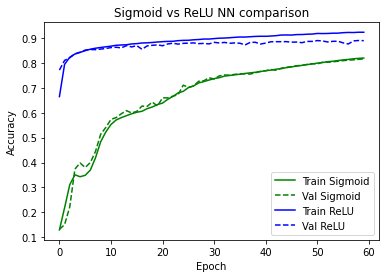

In [43]:
plot_compare_accs(history_sigmoid, history_relu, name1="Sigmoid",
                      name2="ReLU", title="Sigmoid vs ReLU NN comparison")

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

Mencionar que solo se ha elegido modificar el metodo de inicialización weights, ya que como se sabe las bias no influencian mucho en esto.

In [41]:
model_zeros = Sequential()
model_zeros.add(Flatten(input_shape=[28, 28, 1]))
model_zeros.add(Dense(128, kernel_initializer=Zeros(), activation="relu"))
model_zeros.add(Dense(64, kernel_initializer=Zeros(), activation="relu"))
model_zeros.add(Dense(32, kernel_initializer=Zeros(), activation="relu"))
model_zeros.add(Dense(10, kernel_initializer=Zeros(), activation="softmax"))
model_zeros.summary()

model_zeros.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_zeros = model_zeros.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_75 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 628us/step - loss: 2.3026 - accuracy: 0.0992 - val_loss:

In [46]:
model_normal = Sequential()
model_normal.add(Flatten(input_shape=[28, 28, 1]))
model_normal.add(Dense(128, kernel_initializer=RandomNormal(), activation="relu"))
model_normal.add(Dense(64, kernel_initializer=RandomNormal(), activation="relu"))
model_normal.add(Dense(32, kernel_initializer=RandomNormal(), activation="relu"))
model_normal.add(Dense(10, kernel_initializer=RandomNormal(), activation="softmax"))
model_normal.summary()

model_normal.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_normal = model_normal.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_89 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_90 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_91 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 625us/step - loss: 2.2751 - accuracy: 0.1587 - val_loss:

In [47]:
model_glorot = Sequential()
model_glorot.add(Flatten(input_shape=[28, 28, 1]))
model_glorot.add(Dense(128, kernel_initializer=GlorotUniform(), activation="relu"))
model_glorot.add(Dense(64, kernel_initializer=GlorotUniform(), activation="relu"))
model_glorot.add(Dense(32, kernel_initializer=GlorotUniform(), activation="relu"))
model_glorot.add(Dense(10, kernel_initializer=GlorotUniform(), activation="softmax"))
model_glorot.summary()

model_glorot.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_glorot = model_glorot.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_93 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_94 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_95 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 627us/step - loss: 1.4597 - accuracy: 0.5307 - val_loss:

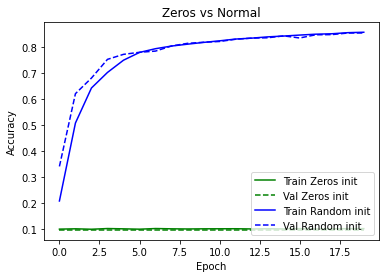

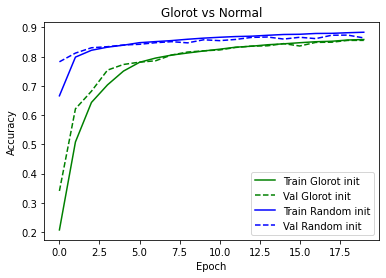

In [48]:
plot_compare_accs(history_zeros, history_normal, name1="Zeros init",
                      name2="Random init", title="Zeros vs Normal")
plot_compare_accs(history_normal, history_glorot, name1="Glorot init",
                      name2="Random init", title="Glorot vs Normal")

## 3. Optimizadores

**Ejercicio 3 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

In [50]:
model_adam = Sequential()
model_adam.add(Flatten(input_shape=[28, 28, 1]))
model_adam.add(Dense(128, kernel_initializer=RandomNormal(), activation="relu"))
model_adam.add(Dense(64, kernel_initializer=RandomNormal(), activation="relu"))
model_adam.add(Dense(32, kernel_initializer=RandomNormal(), activation="relu"))
model_adam.add(Dense(10, kernel_initializer=RandomNormal(), activation="softmax"))
model_adam.summary()

model_adam.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics =["accuracy"])
history_adam = model_adam.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_101 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_102 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_103 (Dense)            (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 682us/step - loss: 0.9992 - accuracy: 0.6140 - val_loss:

In [51]:
model_rmsprop = Sequential()
model_rmsprop.add(Flatten(input_shape=[28, 28, 1]))
model_rmsprop.add(Dense(128, kernel_initializer=RandomNormal(), activation="relu"))
model_rmsprop.add(Dense(64, kernel_initializer=RandomNormal(), activation="relu"))
model_rmsprop.add(Dense(32, kernel_initializer=RandomNormal(), activation="relu"))
model_rmsprop.add(Dense(10, kernel_initializer=RandomNormal(), activation="softmax"))
model_rmsprop.summary()

model_rmsprop.compile(loss="sparse_categorical_crossentropy",
              optimizer= "rmsprop",
              metrics =["accuracy"])
history_rmsprop = model_rmsprop.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_105 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_106 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_107 (Dense)            (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 827us/step - loss: 0.9605 - accuracy: 0.6438 - val_loss:

In [53]:
model_sgd = Sequential()
model_sgd.add(Flatten(input_shape=[28, 28, 1]))
model_sgd.add(Dense(128, kernel_initializer=RandomNormal(), activation="relu"))
model_sgd.add(Dense(64, kernel_initializer=RandomNormal(), activation="relu"))
model_sgd.add(Dense(32, kernel_initializer=RandomNormal(), activation="relu"))
model_sgd.add(Dense(10, kernel_initializer=RandomNormal(), activation="softmax"))
model_sgd.summary()

model_sgd.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history_sgd = model_sgd.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_109 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_110 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_111 (Dense)            (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 1s 631us/step - loss: 2.2987 - accuracy: 0.1291 - val_loss:

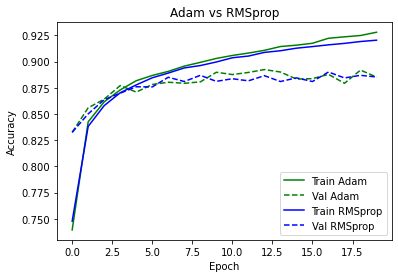

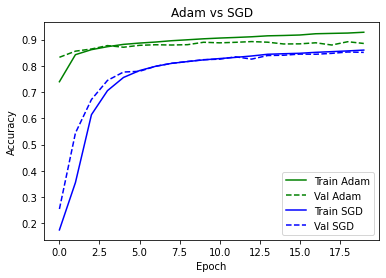

In [74]:
plot_compare_accs(history_adam, history_rmsprop, name1="Adam",
                      name2="RMSprop", title="Adam vs RMSprop")
plot_compare_accs(history_adam, history_sgd, name1="Adam",
                      name2="SGD", title="Adam vs SGD")

## 4. Regularización y red final *(1.25 puntos)*

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

Primeramente se ha elegido un modelo identico utilizando la función de activación $ReLU$ y el optimizador Adam con su configuración por defecto. Seguidamente, como se tenía *overfitting* se ha utilizado la técnica de dropout con una probabilidad de desconexión de neuronas del 50% entre las capas ocultas y también la capa final. Finalmente, se han eliminado un capa oculta y se ha reducido la cantidad de neuronas en las capas ocultas.
Con esto, se ha lógrado reducir la capacidad de la red, aunque todavía se tiene claramente *overfitting*. 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_144 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_145 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
750/750 [==============================] - 1s 599us/step - loss: 0.9974 - accuracy: 0.6555 - val_loss: 0.4934 - val_accuracy: 0.8249
Epoch 2/40
750/750 [==============================] - 0s 529us/step - loss: 0.4558 - accuracy: 0.8392 -

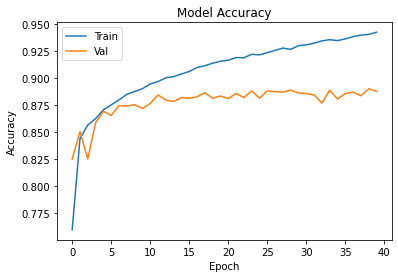

In [75]:
model_final = Sequential()
model_final.add(Flatten(input_shape=[28, 28, 1]))
model_final.add(Dense(32, kernel_initializer=RandomNormal(), activation="relu"))
model.add(Dropout(0.5))
model_final.add(Dense(16, kernel_initializer=RandomNormal(), activation="relu"))
model.add(Dropout(0.5))
model_final.add(Dense(10, kernel_initializer=RandomNormal(), activation="softmax"))
model_final.summary()

model_final.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics =["accuracy"])
history_final = model_final.fit(
    x_train,
    y_train, 
    epochs=40,
    batch_size=64,
    validation_split=0.2
)
plot_acc(history_final, title="Model Accuracy")

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [76]:
model_final.evaluate(x_test, y_test)

313/313 [==============================] - 0s 311us/step - loss: 0.4347 - accuracy: 0.8829


[0.4347131848335266, 0.8828999996185303]